# Project 'hard problems': traveling salesman problem

*Selected Topics in Mathematical Optimization: 2017-2018*

**Michiel Stock** ([email](michiel.stock@ugent.be))

![](Figures/logo.png)

Bram De Jaegher, Daan Van Hauwermeiren

In [1]:
# everything you need for the TSP!
from tsp_utils import *

import random
import pandas as pd
import itertools

%matplotlib inline

## The traveling salesman problem

> **Traveling salesman problem (TSP)**: Given a list of cities and the distances between each pair of cities, find
the *tour* with the lowest possible total cost that visits each city exactly once and returns to
the origin city.

- $n$ cities $x_1,\ldots,x_n$.
- Cost matrix $C[x_i, x_j]$ (possibly symmetric and/or triangle inequality).
- Search space is all permutations of cities: size of $(n-1)!$.
- Objective function: sum of costs of the paths.

For this problem, the 'cities' are represented as points on the 2D plane. The $x,y$-coordinates are stored in the Numpy array `coordinates` and the distances between two cities are found in the Numpy array `distances`.

In [2]:
coordinates[:10]

In [3]:
n = len(coordinates)
print('There are {} cities.'.format(n))

In [4]:
distances[:10,:10]

Cities are referred by their respective index.  A tour is implemented as a list of the permutation of the indices of $n$ cities, e.g. `[0, 1, 2, ..., n-1]`. Note that the cost is invariant w.r.t. cyclic permutations, i.e. the cost is the same independent from which city the tour starts.

In [70]:
tour = list(range(n))

tour

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


Some simple function are provided to compute the length of a given tour and to plot the cities and a tour.

In [6]:
cost = compute_tour_cost(tour, distances)
print('Cost of tour is {:.3f}'.format(cost))

fig, ax = plt.subplots(figsize=(8, 8))
plot_cities(ax, coordinates, color=blue)  # plot cities as a scatter plot
plot_tour(ax, tour, coordinates, distances, color=red, title=True)  # add the tour

A tour can be saved and loaded in a JSON file. You have to hand in your best tour!

In [7]:
save_tour('Data/my_tour.json', tour)

loaded_tour = load_tour('Data/my_tour.json')

In [8]:
!rm Data/my_tour.json

## Assignments

Implement *two* heuristic algorithms for finding a low-cost tour:

- write a report in the notebook discussing your strategy and the final results;
- embed the code with sufficient documentation;
- plot your final best tour in your notebook with the total cost.

In [9]:
# CELLS FOR CODE!
# TINY EXAMPLE FROM MICHIEL

import itertools as it

def yield_some_permutations(tour, mtry):
    """
    Yields mtry permutations of a tour.
    """
    count = 0
    for perm in it.permutations(tour):
        yield perm
        count += 1
        if count > mtry:
            break

def lazy_brute_force(distances, mtry=10000):
    n, _ = distances.shape
    return min(yield_some_permutations(list(range(n)), mtry),
                key=lambda t : compute_tour_cost(t, distances))

In [10]:
%timeit

best_tour = lazy_brute_force(distances, mtry=10000)

In [168]:
cost = compute_tour_cost(best_tour, distances)
print('Cost of tour is {:.3f}'.format(cost))  # improvement!

fig, ax = plt.subplots(figsize=(8, 8))
plot_cities(ax, coordinates, color=blue)  # plot cities as a scatter plot
plot_tour(ax, best_tour, coordinates, distances, color=orange, title=True)  # add the tour

## Project

Construction strategy: nearest insertion

In [134]:
def nearest_insertion(distances,vertex_lst):
    """
    Source: https://paginas.fe.up.pt/~mac/ensino/docs/OR/HowToSolveIt/ConstructiveHeuristicsForTheTSP.pdf
    
    Algorithm
    1. Initialization – Start with a partial tour with just one city i, randomly chosen;
    find the city j for which cij (distance or cost from i to j) is minimum
    and build the partial tour (i, j).
    
    2. Selection – Find cities k and j (j belonging to the partial tour and k not
    belonging) for which ckj is minimized.
    
    3. Insertion – Find the edge {i, j}, belonging to the partial tour, that
    minimizes cik + ckj − cij. Insert k between i and j.
    
    4. If all cities are inserted then STOP, else go back to 2.
    """
    
    tour = []
    distance_df = pd.DataFrame(distances)
    
    # 1. Initialisation: random selection of vertex
    tour.append(random.choice(vertex_lst))
    distance_df.drop(tour[0],inplace=True) # remove from queue
    
    while len(tour)<len(vertex_lst):
        tempMin = 1e10
        k = 0 # vertex to add
        
        # 2. Selection: find closest vertex not in partial tour 
        for index in tour:
            if distance_df[index].min() < tempMin:
                tempMin = distance_df[index].min()
                k = distance_df[index].argmin()
        
        distance_df.drop(k,inplace=True) # Remove from distance matrix so this vertex can't be used again
        
        if len(tour) <= 1: # No insertion if < 2 vertices in partial tour 
            tour.append(k)
        else: 
            
            # 3. Insertion: find the edge in the partial tour that should open to include new vertex 
            edge_lst = [(tour[i],tour[i+1]) for i in range(0,len(tour)-1)] # construct list of edges
            distance_lst = list(map(lambda i: distances[i[0],k] + distances[k,i[1]] -distances[i[0],i[1]],edge_lst)) # compute the distance gain
            insertionInd = min([(v,i) for i,v in enumerate(distance_lst)])[1]+1 # find edge with minimum distance gain
            tour.insert(insertionInd,k) # insert this edge
    return tour

In [135]:
best_tour = nearest_insertion(distances,tour)

Cost of tour is 12323.557


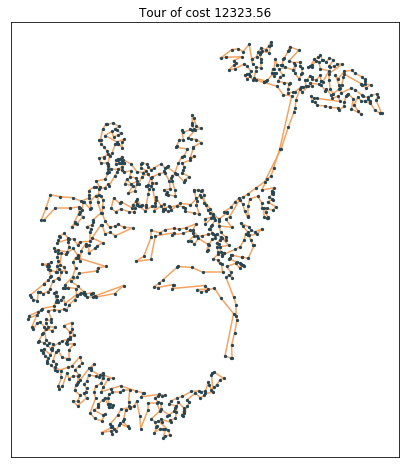

In [136]:
cost = compute_tour_cost(best_tour, distances)
print('Cost of tour is {:.3f}'.format(cost))  # improvement!

fig, ax = plt.subplots(figsize=(8, 8))

plot_cities(ax, coordinates, color=blue)  # plot cities as a scatter plot
plot_tour(ax, best_tour, coordinates, distances, color=orange, title=True)  # add the tour

DESCRIBE YOUR RESULTS